In [1]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import savgol_filter
from sympy.physics.units import temperature

q_table = None
env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode="human")





# Reinforcement Learning: Theory

The **reinforcement learning** is a paradigm of machine learning that often relies on the interaction of **agent** and **environment**.


This is a diagram of the **Markov Decision Process**, which is the best friend of RL and probabilistic decision-making models in general. We'll refer to it as **MDP** for short.

---

### MDP

The **MDP** is described with:
- **States**: all possible states the agent could encounter, $s \in \mathcal{S}$
- **Actions**: set of possible actions, $a \in \mathcal{A}(s)$, for every state
- **Rewards**: set of rewards for $r = R(s) \in \mathbb{R}$, meaning all states have some reward (or none)

---
MDP has an assumption that **previous steps don't affect the underlying probability distribution**, then for discrete time steps it looks like:

$$
p(s', r \mid s, a)
$$

MDP defines the probability of getting new state $s'$ and receiving reward $r$ after taking action $a$ in state $s$.

MDP describes the **environment**, and the **agent** behavior is described within **policy**.

---

## Policy $\pi$

Policy $\pi(a \mid s)$ tells the **probability of taking a particular action** $a$ among $\mathcal{A}(s)$ when being in state $s$.

---

### Return $G_t$

The return $G_t$ is **accumulated rewards over all future time steps**.
Also, we want to consider **closer rewards as more valuable** — for that, we add **discount factor** $\gamma$, so:

$$
G_t = \sum_{k=t+1}^{T} \gamma^{k - t - 1} R_k
$$

---

## Test Run

For this test, the agent follow the **uniform distribution** — this is called the **random policy**.

In [2]:
def run(q_table, episodes = 1, is_slippery = True):
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=is_slippery, render_mode="human")
    policy = q_table

    action_map = {
        0: "LEFT",
        1: "DOWN",
        2: "RIGHT",
        3: "UP"
    }

    for i in range(episodes):
        state = env.reset()[0]
        print(f"Initial state is [{state // 8}, {state % 8}]")
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action_space = policy[state]
            action = np.argmax(action_space)
            print(f"Action is [{action}]")
            print(f"Action is {action_map[action]}]")
            new_state, reward, terminated, truncated,_ = env.step(action)

            state = new_state

            print(f"New state is [{new_state // 8}, {new_state % 8}], reward is {reward}")

    env.close()

    pygame.quit()

In [3]:
q_random = np.random.rand(env.observation_space.n, env.action_space.n)

run(q_random ,episodes = 1)

Initial state is [0, 0]
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [1, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [0, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [1, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [3, 0], reward is 0.0
Action is [0]
Action is LEFT]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 1], reward is 

Now the agent is performing **random actions**, completing the **SARSA loop**, but now it is practically useless.
We need to introduce the way to **improve policy**.

With the idea of return formalized, the **goal for optimal policy** might be described as **maximizing expected return**:

$$
\pi^* = \arg\max_{\pi} \mathbb{E}_\pi [G_t]
$$

---

## Bellman Equations

To make learning tractable, we need a way to break down the expected return into **recursive relationships**.
This is where the **Bellman equations** come in.

---

### State-Value Function $V_\pi(s)$

The **value function** measures the expected return from state $s$, following policy $\pi$:

$$
V_\pi(s) = \mathbb{E}_\pi \left[ G_t \mid S_t = s \right]
$$

Using the return definition, we can derive the **Bellman expectation equation**:

$$
V_\pi(s) = \sum_{a} \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V_\pi(s') \right]
$$

---

### Action-Value Function $Q_\pi(s, a)$

Similarly, for action-value function — the expected return from taking action $a$ in state $s$ and then following policy $\pi$:

$$
Q_\pi(s, a) = \mathbb{E}_\pi \left[ G_t \mid S_t = s, A_t = a \right]
$$

Bellman expectation equation for $Q_\pi$ becomes:

$$
Q_\pi(s, a) = \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma \sum_{a'} \pi(a' \mid s') Q_\pi(s', a') \right]
$$

---

## Generalized Policy Iteration (GPI)

To find the optimal policy $\pi^*$, we can iteratively:
- **evaluate** a policy (compute $V_\pi$ or $Q_\pi$),
- then **improve** it by acting greedily with respect to the value function.

This loop is called **Generalized Policy Iteration (GPI)**.

---

### Policy Improvement Theorem

A new policy $\pi'$ that is greedy with respect to $V_\pi$ will always perform **at least as well**:

$$
\pi'(s) = \arg\max_a Q_\pi(s, a)
$$

If $\pi' \ne \pi$, then $V_{\pi'}(s) > V_\pi(s)$ for some $s$.

We repeat evaluation and improvement until convergence. This gives us the **optimal policy** $\pi^*$.

---

## Monte Carlo (MC) Learning

In most environments, we dont know the model (i.e. the transition probabilities \( p(s', r \mid s, a) \)), but we can still learn from **complete episodes of experience** — this is where **Monte Carlo learning** comes in.

---

### Monte Carlo Target

Monte Carlo methods based on doing the actions, observing their outcomes and estimating the Value function based on observed statistics. MC wait until the **end of an episode** to compute the actual return:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1} R_T
$$

Then the value function is updated as:

$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ G_t - V(S_t) \right]
$$

Here, the **error** is:

$$
\delta_t = G_t - V(S_t)
$$

---

MC learning is **model-free**, uses **complete returns**, and updates **only at the end of episodes**.

---

## Temporal Difference (TD) Learning

While Monte Carlo methods wait until the end of an episode to learn from the complete return, TD learning updates estimates at each time step, using the current reward and the value of the next state.
This allows TD learning to operate online, incorporating this idea of **bootstrapping** by relying on estimates rather than full returns.

---

### TD Target

Instead of waiting until the end to compute $G_t$, we use a **bootstrapped estimate**:

$$
\text{TD Target} = R_{t+1} + \gamma V(S_{t+1})
$$

Then we update our value function like this:

$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ \text{TD Target} - V(S_t) \right]
$$

This difference is called the **TD error**:

$$
\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)
$$



---
## Exploration Strategies

To learn effectively, the agent needs to **explore** the environment, not just exploit what it already knows.
This creates a fundamental trade-off:

> **Exploration vs Exploitation**

---

### $\varepsilon$-Greedy Strategy

One of the simplest strategies:

- With probability $\varepsilon$, pick a **random action** (exploration).
- With probability $1 - \varepsilon$, pick the **greedy action** (exploitation):

$$
a =
\begin{cases}
\text{random action}, & \text{with prob } \varepsilon \\
\arg\max_a Q(s, a), & \text{with prob } 1 - \varepsilon
\end{cases}
$$

Often $\varepsilon$ decays over time (e.g., $\varepsilon_t = \varepsilon_0 \cdot \exp(-kt)$), so exploration decreases as the agent learns more.

---

### Boltzmann (Softmax) Exploration

Instead of hard choices, Boltzmann (or **softmax**) exploration **samples actions according to their estimated values**.

Probability of taking action $a$ in state $s$:

$$
\pi(a \mid s) = \frac{\exp\left( Q(s, a) / \tau \right)}{\sum_{a'} \exp\left( Q(s, a') / \tau \right)}
$$

Where:

- $\tau$ is the **temperature** parameter.
  - High $\tau$: more uniform distribution (more exploration).
  - Low $\tau$: more greedy (exploitation).

---

### Intuition Behind Boltzmann

- Boltzmann is smoother than $\varepsilon$-greedy — **more nuanced**.
- It gives **better control** over the exploration spectrum.
- With appropriate tuning of $\tau$, the agent can **gradually shift** from exploring to exploiting.


# Environment

Now, when all the necessary theory is described we could move to explaining MDP.

For this part I am using the Frozen Lake 8x8 from gymnasium.

### States

The states are represented as an \(8 \times 8\) grid:

$$
\mathcal{S} = \{0, 1, 2, \dots, 63\}
$$

The index of the \((i, j)\) position in the grid is calculated as:

$$
\text{idx\_pos}(i, j) = 8i + j
$$

Where the **start** state is $s_0 = 0$, the **goal** (or **win**) state is $s_{\text{goal}} = 63$, and the set of **terminal** states is: $S_{\text{terminal}} = \{19, 29, 35, 41, 42, 46, 49, 52, 54, 59\}$


### Actions

The actions are the same for every state (i.e., moving into an invalid direction such as off the grid keeps the agent in the same position). The set of possible actions is:

$$
\mathcal{A} = \{\uparrow, \downarrow, \leftarrow, \rightarrow\}
$$

Such that for all $s \in S$, the available actions are:

$$
\forall s \in S : \mathcal{A}(s) = \mathcal{A}
$$

### Rewards

In the vanilla environment, the MDP has only one reward of 1 when transition to the **goal** state. However for the training I will experiment with different rewards to investigate how rewards influence training process.


---

This MDP has two variations, **deterministic** and **stochastic** I will experiment with both. The **stochastic** version has a probability of making action perpendicular to selected.


# Implementation

Firstly, I will implement the helper functions to visualize the state space to access the insights of the MDP and see the dynamics of the training process. The `plot_q_table` function hase three options of visualisation `max`, `mean` and `min` that aims to explore different aspects of training. The `max` mode will show the largest action value given the state, then this is the value function of the state according to greedy policy. The `min` mode might be interpreted as the danger zones, which states are the closest to the termination. The `mean` mode gives more general idea of the state value by calculating $V(s) = \sum_i \pi(a_i) \cdot Q(s, a_i)$.

In [19]:
def softmax(x, axis=None):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def plot_q_table(q_table, episode = None, mode = "max", show_action = True):
    if mode == "mean":
        probs = softmax(q_table, axis=1)
        values = np.sum(probs * q_table, axis=1)
    elif mode == "min":
        values = q_table.min(axis=1)
    else:
        values = q_table.max(axis=1)

    values_grid = values.reshape(8,8)

    plt.imshow(
        values_grid,
        origin='upper',
        extent=[0, 8, 0, 8],
        interpolation='nearest',
        aspect='equal'
    )
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

    holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

    ax = plt.gca()
    for (row, col) in holes:
        rect = plt.Rectangle(
                (col, row),
                1, 1,
                fill=True,
                color='red',
                alpha=1
            )
        ax.add_patch(rect)

    rect = plt.Rectangle(
                (7, 0),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    rect = plt.Rectangle(
                (0, 7),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    plt.title("Value table" + f"at step #{episode}" if episode is not None else "")
    plt.colorbar()
    plt.show()



    if show_action:
        actions = q_table.argmax(axis=1)

        actions_grid = actions.reshape(8,8)

        plt.imshow(
            values_grid,
            origin='upper',
            extent=[0, 8, 0, 8],
            interpolation='nearest',
            aspect='equal'
        )
        plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

        holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

        ax = plt.gca()
        for (row, col) in holes:
            rect = plt.Rectangle(
                    (col, row),
                    1, 1,
                    fill=True,
                    color='red',
                    alpha=1
                )
            ax.add_patch(rect)

        rect = plt.Rectangle(
                    (7, 0),
                    1, 1,
                    fill=True,
                    color='green',
                    alpha=1
                )
        ax.add_patch(rect)

        rect = plt.Rectangle(
                    (0, 7),
                    1, 1,
                    fill=True,
                    color='green',
                    alpha=1
                )
        ax.add_patch(rect)

        for y in range(8):
            for x in range(8):
                # (0,0)  (y,x)-> (0, 7)(x, 7 - y)

                action = actions_grid[y, x]

                match action:
                    case 0:
                        # top
                        start_y, start_x ,arrow_x, arrow_y = 0.2, 0.5, 0 , 0.2
                    case 1:
                        # bot
                        start_y, start_x ,arrow_x, arrow_y = 0.8, 0.5, 0 , -0.2
                    case 2:
                        # right
                        start_y, start_x ,arrow_x, arrow_y = 0.5, 0.2 , 0.2 , 0
                    case 3:
                        # left
                        start_y, start_x ,arrow_x, arrow_y = 0.5, 0.8 , -0.2 , 0
                    case _:
                        print("Unknown action")


                plt.arrow(x + start_x, 7 - y + start_y, arrow_x, arrow_y, width = 0.1)

        plt.title("Policy table" + f"at step #{episode}" if episode is not None else "")
        plt.colorbar()
        plt.show()

## Training Function

The `train` function executes multiple learning episodes in the FrozenLake environment using a configurable n-step TD approach, exploration, and reward shaping.

### Parameters

- `episodes`: total number of training episodes.
- `lr`: learning rate for Q-value updates.
- `gamma`: discount factor.
- `td_num`: number of steps for n-step returns.
- `cost_of_living`: step penalty applied at each timestep.
- `termination_reward`: penalty for falling into a terminal state.
- `T`: maximum number of steps per episode.
- `render`: whether to visualize learning progress periodically.
- `isSlippery`: toggles between deterministic and stochastic dynamics in the environment.
- `label`: title used in the learning curve plot.
- `draw_q_table`: list of episode indices where the Q-table is visualized.
- `truncated_penalty`: penalty applied if the agent hits the step limit.
- `exploration_strategy`: either `"epsilon"` or `"boltzmann"`.
- `temperature`: used for softmax scaling in Boltzmann exploration.

### Execution Flow

1. **Environment and Q-table setup**
   Initializes the 8×8 FrozenLake environment and a zeroed Q-table of shape `(64, 4)`.
   Sets up tracking arrays for rewards, success rates, and episode lengths.

2. **Episode loop**
   For each episode:
   - The environment is reset and the agent starts with an empty trajectory.
   - For up to `T` steps:
     - Action is selected based on the policy and exploration strategy.
     - Environment transitions are executed and stored in the trajectory.
     - Rewards are modified based on outcome (finished(goal), terminated(fail), or truncated(time limit)).
     - When `td_num` transitions are available, Q-values are updated using the accumulated discounted return. If no termination occurred, the target includes a bootstrapped value from the last state in the window.
   - After termination or truncation, the remaining transitions in the buffer are updated similarly (without bootstrapping).

3. **Exploration decay**
   Epsilon is linearly decayed each episode to reduce exploration.

4. **Visualization**
   At fixed intervals (`draw_q_table`), the function plots a heatmap of the current Q-table using one of three modes: `max`, `mean`, or `min`.

5. **Post-training metrics**
   Plots a smoothed learning curve and prints:
   - Mean reward over the final 10% of episodes.
   - Success rate and mean number of steps for successful episodes.
   - Final Q-table if rendering is enabled.



In [27]:
def train(
        episodes=4000,
        lr=1e-2,
        gamma=0.9,
        td_num=4,
        cost_of_living=0.01,
        termination_penalty=1,
        T=100,
        render=True,
        isSlippery=True,
        label="base",
        draw_q_table=None,
        truncated_penalty=0,
        exploration_strategy = "boltzmann",
        temperature = 2,):

    if draw_q_table is None:
        draw_q_table = range(episodes // 5, episodes, episodes // 5)

    pygame.init()
    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    success_rate = np.zeros(episodes)
    steps_per_episode = []

    for episode in range(episodes):
        trajectory = []
        state = env.reset()[0]
        steps = 0
        total_reward = 0

        for t in range(T):

            if epsilon != 0:
                if exploration_strategy == "epsilon":
                    if np.random.random() < epsilon:
                        action = env.action_space.sample()

                elif exploration_strategy == "boltzmann":
                    if epsilon != 0:
                        preferences = q_table[state] / temperature
                        exp_prefs = np.exp((preferences)/ temperature)
                        probs = exp_prefs / np.sum(exp_prefs)
                        action = np.random.choice(len(probs), p=probs)
            else:
                action = np.argmax(q_table[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            # Adjust reward for falling into a hole
            if terminated and (reward == 0):
                reward = reward - termination_penalty

            if reward == 1:
                success_rate[episode] = 1.0
                time_rewards_per_episode[episode] = 1
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps

            # episode truncated
            if t == 99:
                reward = reward - truncated_penalty

            reward -= cost_of_living

            total_reward += reward

            # Store transition with termination info
            trajectory.append((state, action, reward, new_state, terminated))

            # Process n-step updates
            while len(trajectory) >= td_num:
                # Pop the oldest transition
                oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated = trajectory.pop(0)

                G = oldest_reward
                current_gamma = gamma
                term_in_window = oldest_terminated

                # Sum rewards for next (td_num-1) steps or until termination
                for k in range(1, td_num):
                    if (k-1) >= len(trajectory):
                        break
                    entry = trajectory[k-1]
                    r_k, term_k = entry[2], entry[4]
                    G += current_gamma * r_k
                    current_gamma *= gamma
                    if term_k:
                        term_in_window = True
                        break

                # Add discounted Q-value if no termination in the window
                if not term_in_window and len(trajectory) >= (td_num-1):
                    last_entry = trajectory[td_num-2]  if td_num != 1 else (oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated)
                    last_state = last_entry[3]
                    if not last_entry[4]:
                        G += current_gamma * np.max(q_table[last_state])

                # Update Q-value
                q_table[oldest_state][oldest_action] += lr * (G - q_table[oldest_state][oldest_action])

            state = new_state
            if terminated or truncated:
                break

        # Process remaining transitions after episode ends
        while len(trajectory) > 0:

            oldest_entry = trajectory.pop(0)
            s, a, r, s_new, term = oldest_entry

            G = r
            current_gamma = gamma

            for k in range(1, len(trajectory)+1):
                if (k-1) >= len(trajectory):
                    break
                entry = trajectory[k-1]
                r_k, term_k = entry[2], entry[4]
                G += current_gamma * r_k
                current_gamma *= gamma

            # No Q-value added after episode termination
            q_table[s][a] += lr * (G - q_table[s][a])

        # Decay exploration and learning rate
        epsilon = max(epsilon - epsilon_decay, 0)
        rewards_per_episode[episode] = total_reward
        # if epsilon == 0:
        #     lr *= 0.1  # Decay learning rate after exploration stops

        # print(f"Episode {episode} | Reward: {rewards_per_episode[episode]} | Epsilon: {epsilon}")

        if render and (episode in draw_q_table):
            print("__________________________________")
            plot_q_table(q_table, episode)

    env.close()
    pygame.quit()

    print("__________________________________")
    print("Learning curve")
    if render:
        plt.plot(rewards_per_episode)

    moving_average_window = episodes // 10
    moving_averages = savgol_filter(rewards_per_episode, moving_average_window, 5)


    plt.plot(moving_averages, label=f'{label}')
    plt.title(label)
    plt.legend()
    if render:
        plt.show()

    print("__________________________________")
    print(f"{label}")
    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode)*0.9):])
    mean_success_rate = np.mean(success_rate[int(len(success_rate)*0.9):])
    print(f"Mean reward: {mean_reward_rate}")
    print(f"Mean success rate: {mean_success_rate}")
    if steps_per_episode:
        mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode)*0.9):])
        print(f"Mean steps per success episode: {mean_steps}")
    else:
        print("No successful episodes to calculate mean steps.")
    if render:
        print("__________________________________")
        print("Final Q_Table:")
        plot_q_table(q_table)

    return mean_success_rate


# Experiments

Now, when the train function is implemented we could check whether it is correct by running the training on deterministic env(`slippery = False`) in such case, we except agent to quickly find the optimal policy.

__________________________________


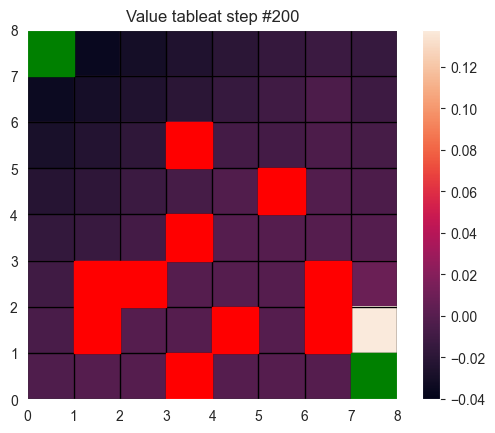

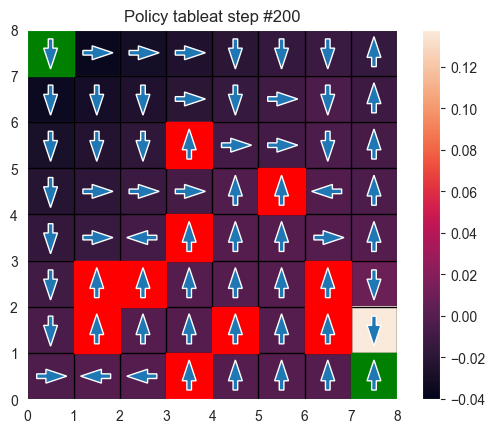

__________________________________


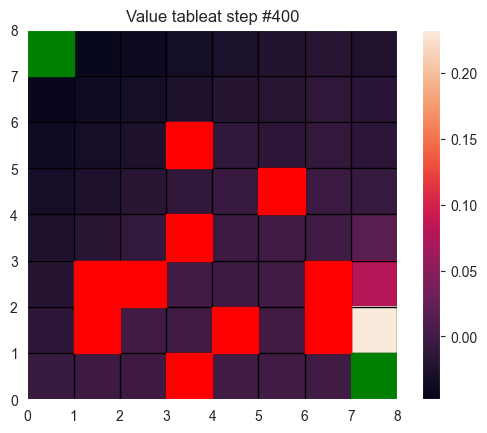

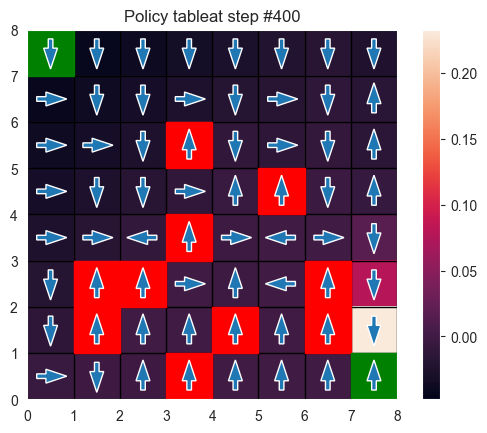

__________________________________


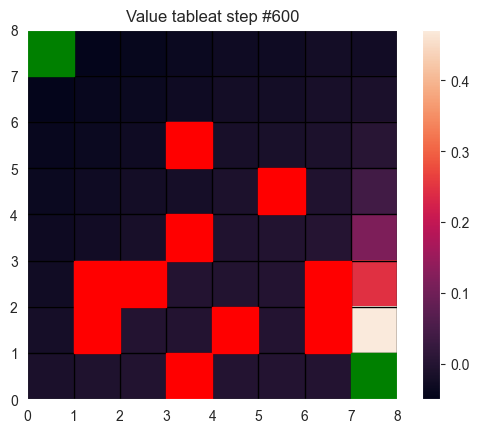

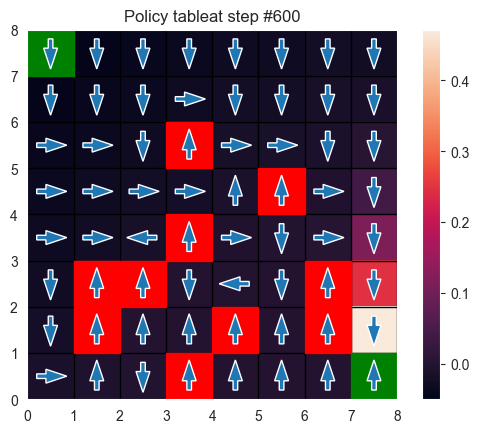

__________________________________


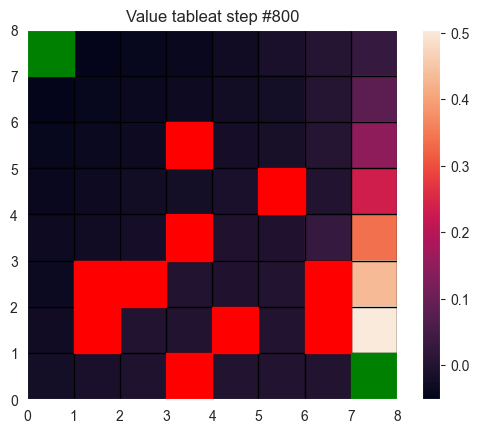

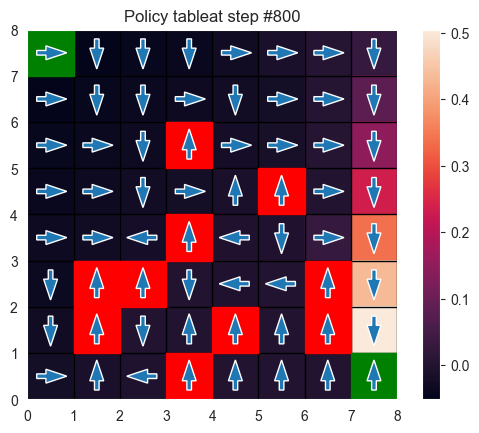

__________________________________
Learning curve


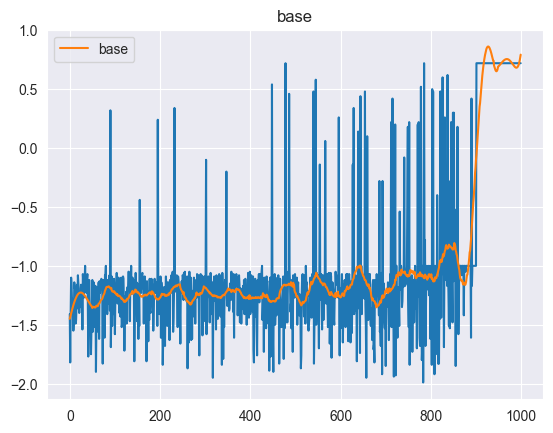

__________________________________
base
Mean reward: 0.7027999999999999
Mean success rate: 0.99
Mean steps per success episode: 14.0
__________________________________
Final Q_Table:


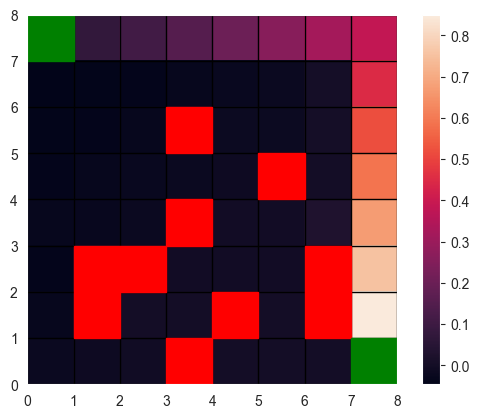

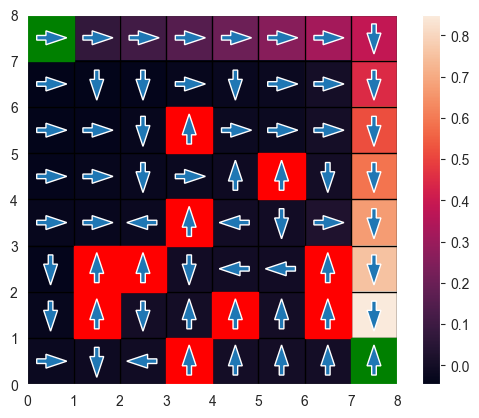

np.float64(0.99)

In [38]:
train(episodes=1000,
      td_num=1,
      lr=0.1,
      isSlippery=False,
      exploration_strategy="epsilon",
      termination_penalty=1
      )

### Results
The learning curve shows a gradual increase in rewards over time. The plots of state values indicate that the model successfully found at least one successful trajectory within the first 200 episodes (as seen in the learning curve, this occurred around episode 180). The reason the moving average reward didn’t immediately jump to a consistent winning rate is due to ongoing exploration — in the early stages, the probability of taking a random action is still high. This is intentional, as it allows the agent to potentially discover better or faster paths to the goal state.
All subsequent state value plots show the agent incrementally building the shortest path from the goal back to the start, by updating the values of states that lead into already optimal segments of the trajectory. These values propagate backward to the start state through bootstrapping.
By the end of the training process, we observe a steady increase in mean reward, which corresponds to the decreasing probability of random actions — the agent begins to exploit the policy it has discovered. In the final 10% of training, the reward values converge to 1 across all episodes, indicating that exploration has ceased and the agent is fully exploiting the learned policy.

Min values for each state


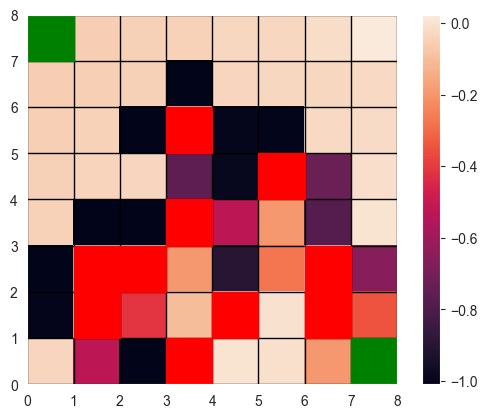

In [39]:
print("Min values for each state")
plot_q_table(q_table, mode="min", show_action=False)

# print("Weighted values for each state")
# plot_q_table(q_table, mode="mean", show_action=False)

#### Q-table insights

The `min` display mode highlights the danger areas for the agent — states where termination is possible. Some of these states are not marked with significantly negative values. This indicates that the agent hasn’t frequently taken the specific actions in those states that lead to termination. These regions typically correspond to clusters of holes: when the agent first enters such areas, it often fails early and doesn’t get the chance to fully explore the rest of the path. As the exploration rate decreases, the agent stops attempting those risky trajectories, resulting in underexplored state-action pairs.

States near the goal show non-zero values that are still noticeably higher (i.e., less negative) than others. This reflects that the agent is close enough to the goal that — in the absence of exploration — it would reliably reach the end. However, due to residual exploration, it occasionally chooses actions that lead to termination. Because these failure cases are rare, the Q-values haven’t fully converged to their true expectations. For instance, the state at `[1,7]` has a value around `-0.3`; with a learning rate of `0.01`, this suggests the agent has explored the terminating action in that state only about 30 times — not enough for accurate value estimation.


---

## TD-num = 5

The next run will use TD learning with 5 steps

__________________________________


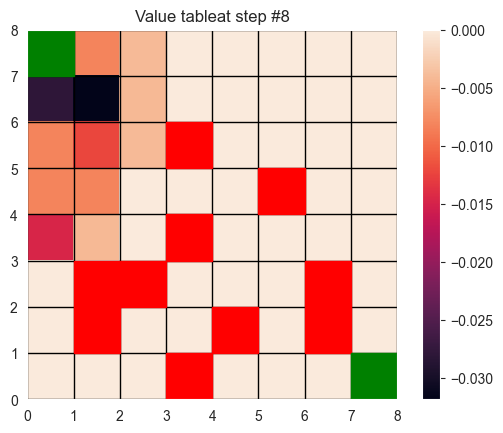

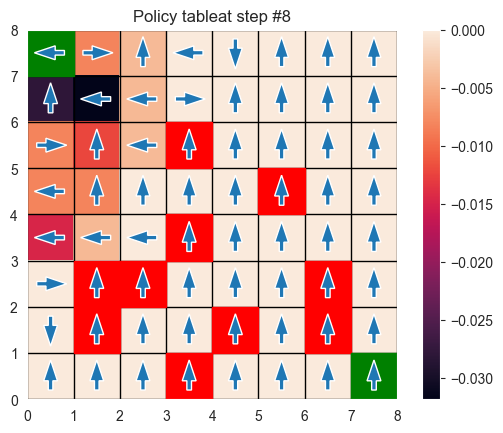

__________________________________


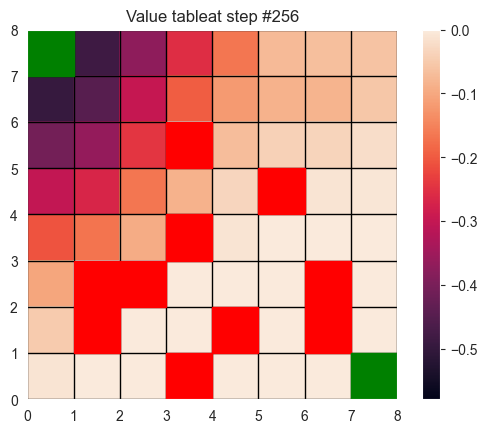

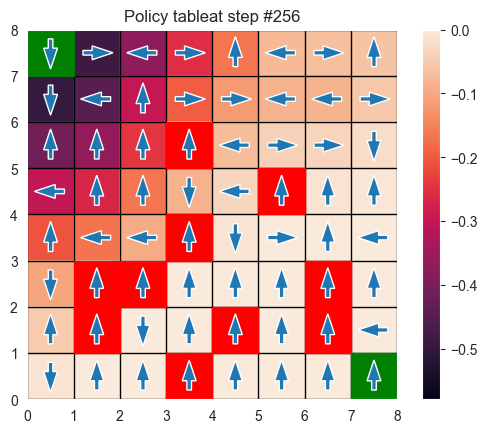

__________________________________
Learning curve


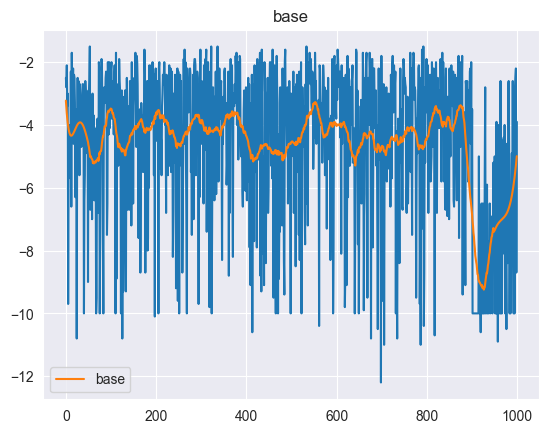

__________________________________
base
Mean reward: -7.64499999999999
Mean success rate: 0.0
Mean steps per success episode: 66.0
__________________________________
Final Q_Table:


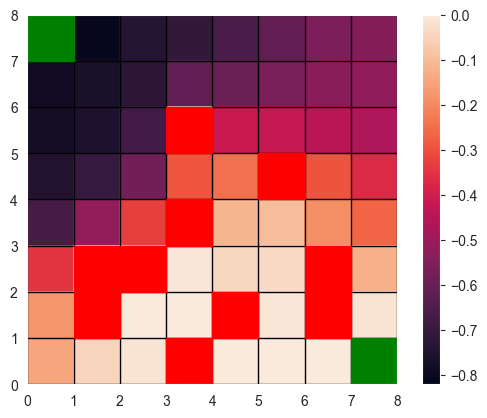

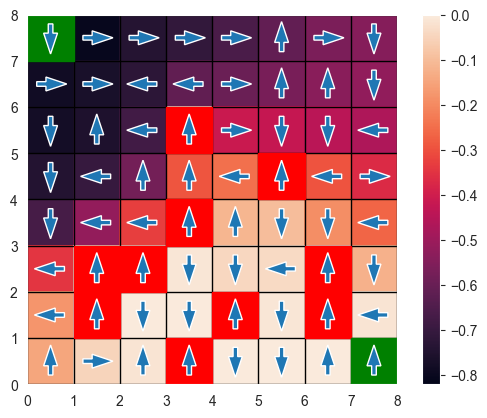

np.float64(0.0)

In [25]:
train(episodes=1000,
      td_num=5,
      lr=0.01,
      cost_of_living=0.1,
      isSlippery=False,
      draw_q_table=[8, 256, 2048, 8096])


The temporal difference learning approach showed worse performance and failed to converge to the optimal policy. This is largely due to the structure of the Frozen Lake environment, which is better suited to one-step updates. In this environment, we care less about long-term strategy and more about identifying which immediate actions lead to termination (i.e., falling into a hole).

Using TD with 5-step returns introduces issues: when the agent falls into a hole, the update affects the entire preceding sequence of five actions. In such a small environment, this tends to mark all early actions in the trajectory as poor choices. Since the only positive reward is at the terminal goal state, the agent often ends up learning that it's safer to wander in circles rather than risk termination. This is reflected at the end of training, where — once the agent starts exploiting — we observe reward values around -10, indicating that it takes all 100 steps without reaching the goal.

I initially tried to address this by adding a truncation penalty, hoping to discourage episodes that run out of time. However, this proved ineffective. Due to the Markov assumption — that $p(s', r \mid s, a)$ depends only on the current state and action — penalizing truncation does not propagate backward in a meaningful way. It only marks the final steps as failures, without correctly attributing blame across the full trajectory. This leads to misleading value estimates, particularly for states where the agent was simply stalling, not making fundamentally poor decisions.


---

### Stochastic Env

next will test the stochastic env by turning is slippery to true

__________________________________


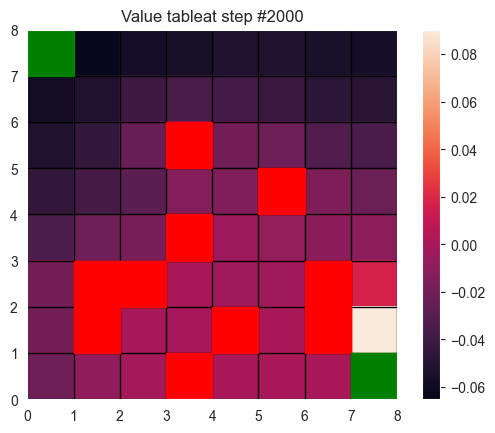

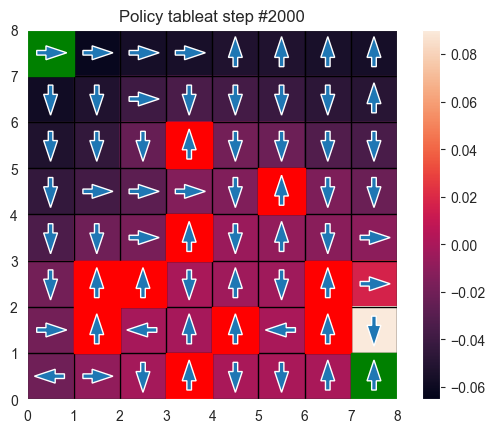

__________________________________


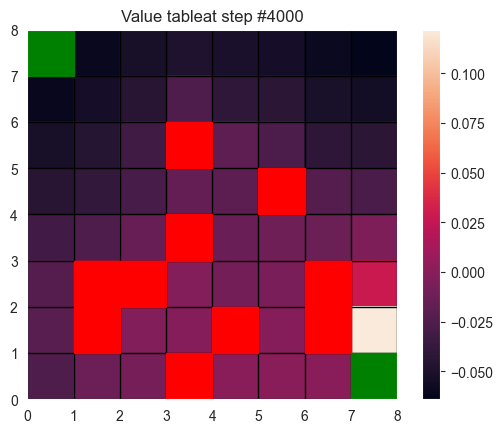

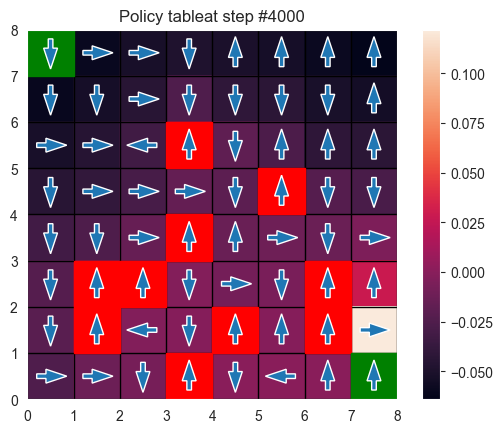

__________________________________


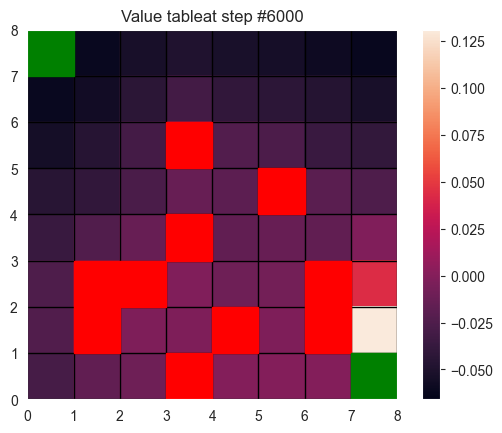

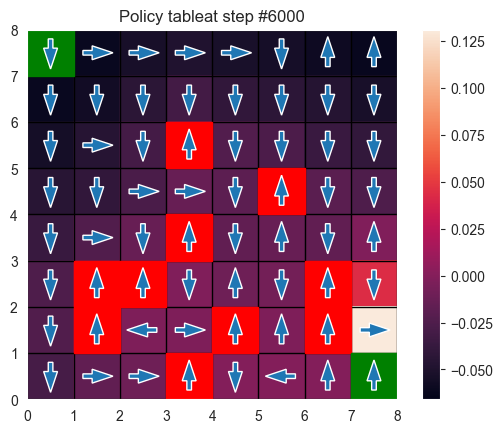

__________________________________


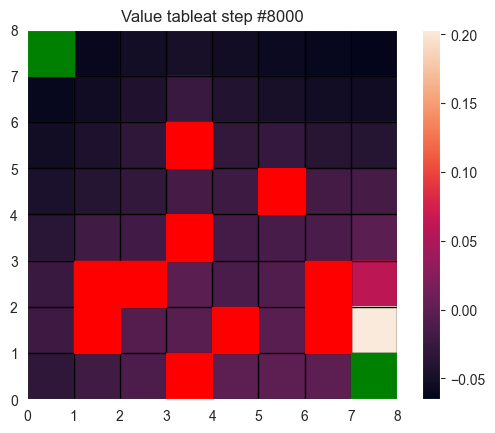

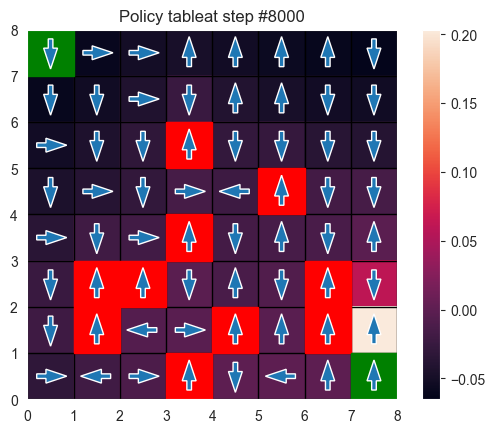

__________________________________
Learning curve


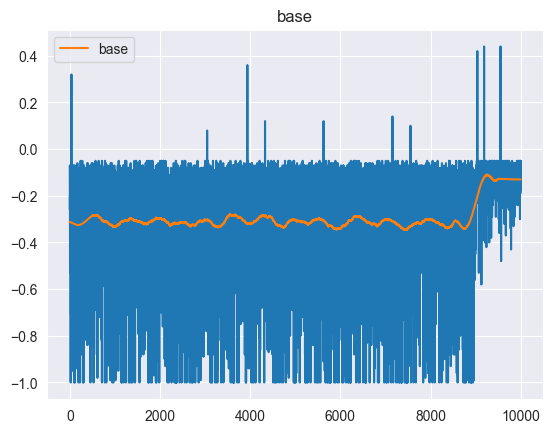

__________________________________
base
Mean reward: -0.12901
Mean success rate: 0.003
Mean steps per success episode: 28.333333333333332
__________________________________
Final Q_Table:


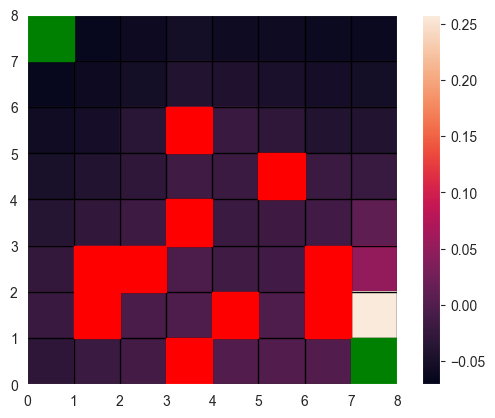

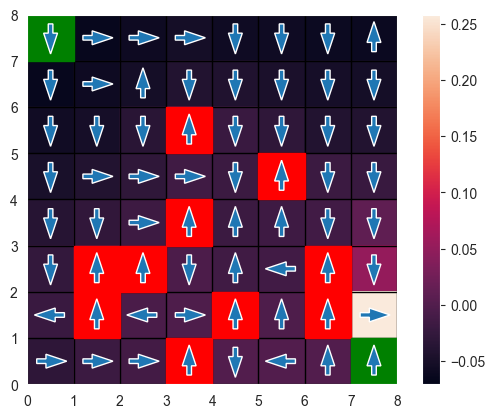

np.float64(0.003)

In [28]:
train(episodes=10000,
      td_num=1,
      lr=0.1,
      isSlippery=True,
      termination_penalty=0
      )

The agent didnt find the optimal policy, this is

__________________________________
Learning curve
__________________________________
LR 0.0001
Mean reward: -1.2396200000000004
Mean success rate: 0.015
Mean steps per success episode: 56.42857142857143
__________________________________
Learning curve
__________________________________
LR 0.01
Mean reward: -1.0796800000000002
Mean success rate: 0.16
Mean steps per success episode: 61.285714285714285
__________________________________
Learning curve
__________________________________
LR 0.1
Mean reward: -0.6937800000000004
Mean success rate: 0.514
Mean steps per success episode: 63.6551724137931
__________________________________
Learning curve
__________________________________
LR 0.5
Mean reward: -0.7858600000000004
Mean success rate: 0.376
Mean steps per success episode: 69.04651162790698


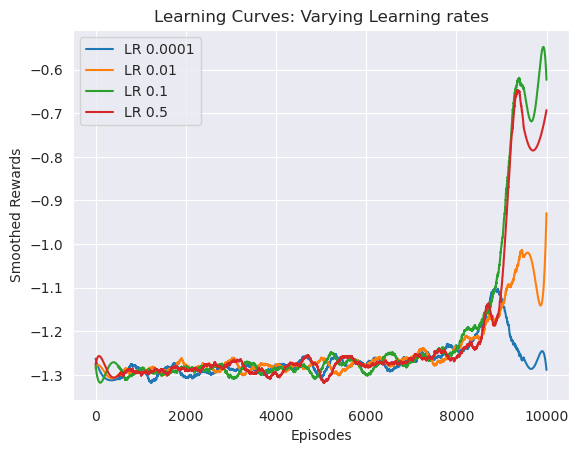

In [65]:
train(episodes=10000, lr=0.0001, label="LR 0.0001", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.01, label="LR 0.01", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.1, label="LR 0.1", render=False, exploration_strategy="epsilon", td_num= 1)
train(episodes=10000, lr=0.5, label="LR 0.5", render=False, exploration_strategy="epsilon", td_num= 1)

plt.title("Learning Curves: Varying Learning rates")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


test boltzmann exploration

__________________________________
Learning curve
__________________________________
T=1
Mean reward: -0.7348900000000005
Mean success rate: 0.477
Mean steps per success episode: 67.31372549019608
__________________________________
Learning curve
__________________________________
T=2
Mean reward: -0.6983000000000004
Mean success rate: 0.491
Mean steps per success episode: 61.01960784313726
__________________________________
Learning curve
__________________________________
T=5
Mean reward: -0.6612400000000005
Mean success rate: 0.563
Mean steps per success episode: 66.96551724137932
__________________________________
Learning curve
__________________________________
T=10
Mean reward: -0.6867700000000004
Mean success rate: 0.514
Mean steps per success episode: 67.16981132075472


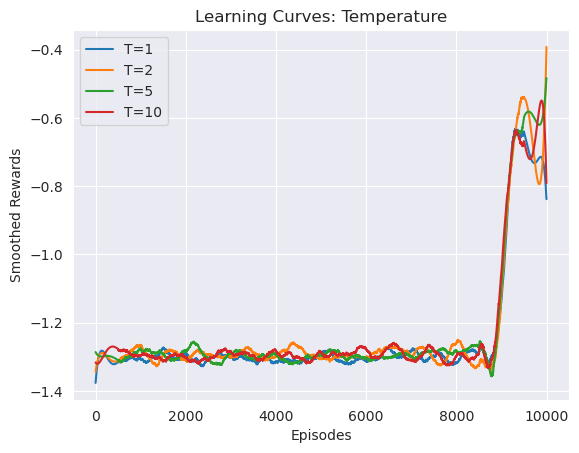

In [71]:
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=1, label="T=1")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=2, label="T=2")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=5, label="T=5")
train(episodes=10000, lr=0.1, render=False, td_num=1, exploration_strategy="boltzmann", temperature=10, label="T=10")

plt.title("Learning Curves: Temperature")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()

Training Boltzmann | td_num=1, lr=0.001
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.001
Mean reward: -1.1973450000000003
Mean success rate: 0.091
Mean steps per success episode: 65.9090909090909
Training Boltzmann | td_num=1, lr=0.05
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.05
Mean reward: -0.6503450000000005
Mean success rate: 0.565
Mean steps per success episode: 64.02586206896552
Training Boltzmann | td_num=1, lr=0.1
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.1
Mean reward: -0.6614800000000005
Mean success rate: 0.5345
Mean steps per success episode: 65.27927927927928
Training Boltzmann | td_num=1, lr=0.5
__________________________________
Learning curve
__________________________________
Boltzmann_td1_lr0.5
Mean reward: -0.8340000000000004
Mean success rate: 0.29
Mean steps per success episode: 70.354838

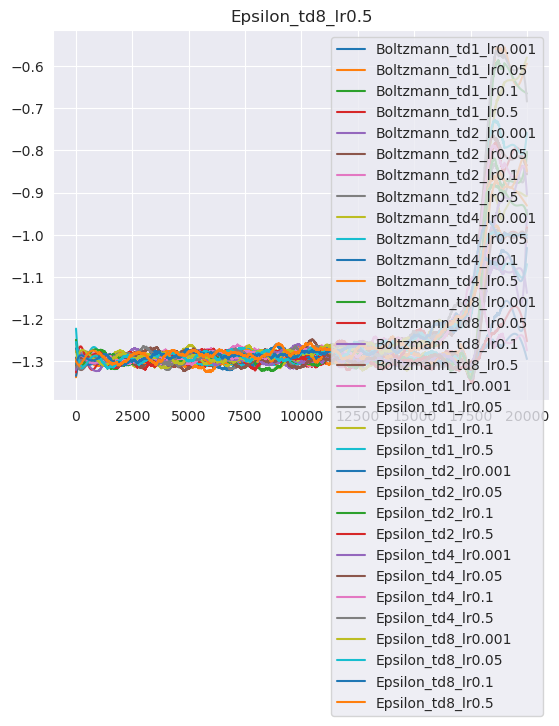

In [81]:
# Define benchmark settings
td_nums = [1, 2, 4, 8]
learning_rates = [1e-3, 5e-2, 1e-1, 5e-1]
episodes = 20000

# Store results
boltzmann_rewards = np.zeros((len(td_nums), len(learning_rates)))
epsilon_rewards = np.zeros((len(td_nums), len(learning_rates)))

# Run training for all combinations with actual train function
for i, td_num in enumerate(td_nums):
    for j, learning_rate in enumerate(learning_rates):
        print(f"Training Boltzmann | td_num={td_num}, lr={learning_rate}")
        mean_reward = train(
            episodes=episodes,
            lr=learning_rate,
            td_num=td_num,
            render=False,
            exploration_strategy="boltzmann",
            temperature=2,
            label=f"Boltzmann_td{td_num}_lr{learning_rate}"
        )
        boltzmann_rewards[i, j] = mean_reward

for i, td_num in enumerate(td_nums):
    for j, learning_rate in enumerate(learning_rates):
        print(f"Training Epsilon | td_num={td_num}, lr={learning_rate}")
        mean_reward = train(
            episodes=episodes,
            lr=learning_rate,
            td_num=td_num,
            render=False,
            exploration_strategy="epsilon",
            label=f"Epsilon_td{td_num}_lr{learning_rate}"
        )
        epsilon_rewards[i, j] = mean_reward

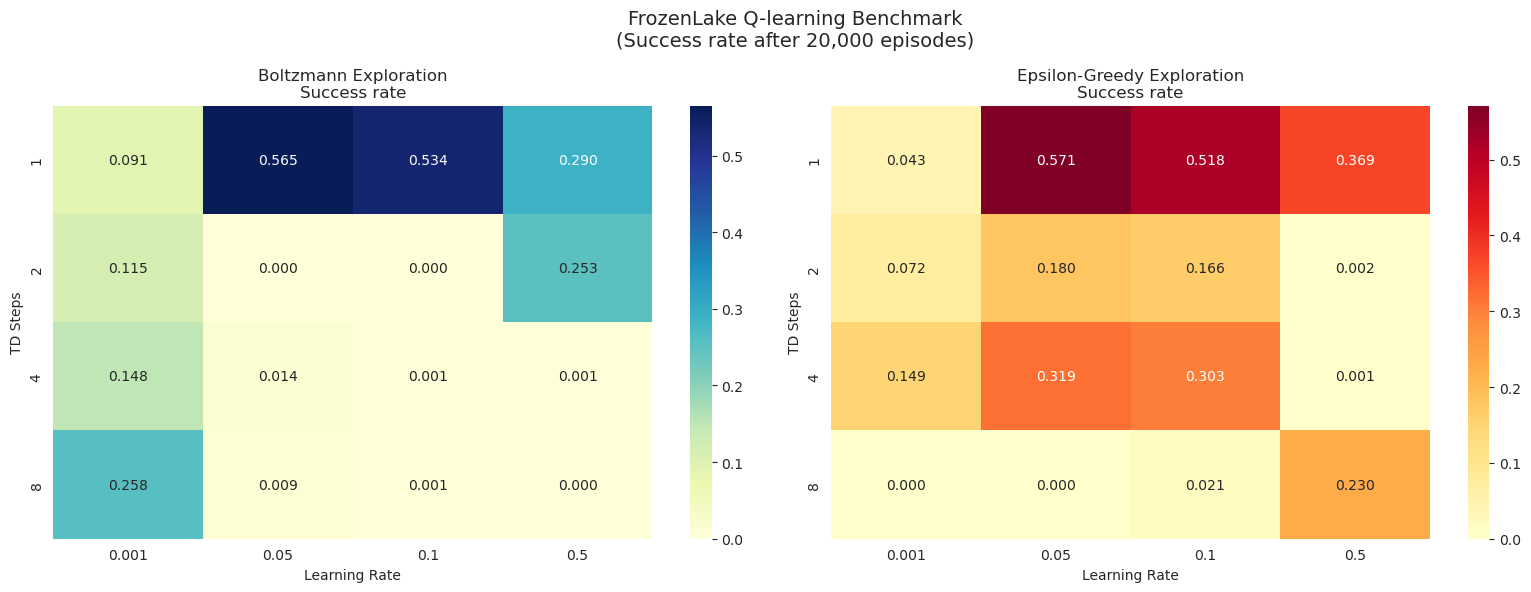

In [82]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    boltzmann_rewards,
    xticklabels=learning_rates,
    yticklabels=td_nums,
    cmap="YlGnBu",
    annot=True,
    fmt=".3f",
    ax=axes[0],
)
axes[0].set_title("Boltzmann Exploration\nSuccess rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("TD Steps")

sns.heatmap(
    epsilon_rewards,
    xticklabels=learning_rates,
    yticklabels=td_nums,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
)
axes[1].set_title("Epsilon-Greedy Exploration\nSuccess rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("TD Steps")

plt.suptitle("FrozenLake Q-learning Benchmark\n(Success rate after 20,000 episodes)", fontsize=14)
plt.tight_layout()
plt.show()